# Summary

Explore derivation of Lagrangian. 

### Preliminaries

In [1]:
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np, os
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, expand, factor, collect, \
    Rational, Eq, solve, sqrt, cbrt, Matrix, diff, pi, \
    poly, lambdify, N, numer, denom, trigsimp, Abs, \
    sin, cos, tan, atan
from scipy.optimize import root_scalar
from scipy.linalg import norm

# Import Geomorphysics library functions
from gmplib.utils import e2d

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations

from gmplib.plot_utils import GraphingBase

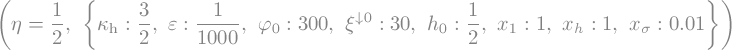

In [2]:
eta_ = Rational(1,2)
sub = {
        x_1: 1, 
        varepsilon: Rational(1,1000), 
        varphi_0: 300,
        xiv_0: 30,
        kappa_h: Rational(3,2),
        h_0: Rational(1,2),
        x_sigma: 0.01,
        x_h: 1
}
Eq(eta,eta_), sub

In [3]:
# prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

# suffix = f'_eta{float(sy.N(gmeq.eta))}'
# suffix += f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.2f}' if gmeq.mu/gmeq.eta==Rational(1,3) \
#                                     else f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.1f}'
# suffix += f'_xiv{float(sy.N(pr.model.xiv_0)):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

# job_name = prefix+suffix
# hamiltonian_sinbeta_ramp_eta0p25_ratio2p0_xiv1000
job_name = 'lagrangian_demo'
gr = GraphingBase()

# Recap of Hamiltonian, front and ray angles

In [4]:
gmeq = Equations(eta=eta_)

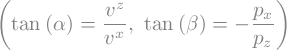

In [5]:
gmeq.tanalpha_rdot_eqn, gmeq.tanbeta_pxpz_eqn

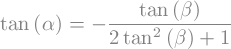

In [6]:
gmeq.tanalpha_beta_eqn

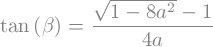

In [7]:
tanbeta_eqn = gmeq.tanbeta_alpha_eqns[0].subs({tan(alpha):ta})
tanbeta_eqn

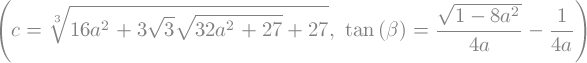

In [8]:
c_a_eqn = Eq(c,((16*ta**2+3*sqrt(3)*sqrt((32*ta**2+27))+27)**Rational(1,3)) )
tanbeta_c_a_eqn = Eq(tanbeta_eqn.lhs, expand(tanbeta_eqn.rhs.subs({c_a_eqn.rhs:c})) )
c_a_eqn, tanbeta_c_a_eqn

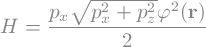

In [9]:
gmeq.H_eqn

# Find an on-shell point in T*M

To test our derivations, at minimum we need a point in slowness phase space that is on-shell, along with its counterpart in velocity phase space. We start with setting some model constants.

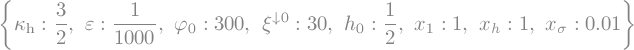

In [10]:
sub

Let's arbitrarily choose $x=0$, as if we were choosing a viable boundary condition. We first need the erosion rate $\xi(0)$:

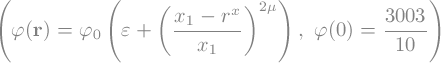

In [11]:
varphi_ = gmeq.varphi_rx_eqn.rhs.subs(sub).subs({rx:0})
gmeq.varphi_rx_eqn, Eq(varphi_rx.subs({rx:0}),varphi_)

From the erosion model, derive an equation in terms of $p_x$, $u^\downarrow$ and $\xi$ only:

In [12]:
# gmeq.px_pz_xi_varphi_eqn
gmeq.px_xiv_varphi_eqn

In [13]:
# px_varphi_xiv_eqn = simplify( Eq( gmeq.xiv_varphi_pxpz_eqn.lhs**2/xiv**2,
#                                     gmeq.xiv_varphi_pxpz_eqn.rhs**2/xiv**2) )
# expand(px_varphi_xiv_eqn), expand(px_varphi_xiv_eqn).subs({varphi_r:varphi_})

and convert into a polynomial in $p_x$ for the chosen point:

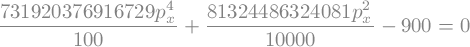

In [14]:
px_eqn = gmeq.px_xiv_varphi_eqn.subs({varphi_r:varphi_})\
                    .subs({xiv:xiv_0}).subs(sub)
px_eqn

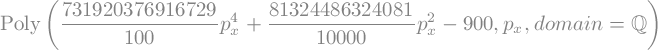

In [15]:
px0_poly_eqn = poly(px_eqn)
px0_poly_eqn

Find the value of $p_x$ at this point $x=0$:

In [16]:
px0_poly_lambda = lambdify( [px], px0_poly_eqn.as_expr() )
dpx0_poly_lambda = lambdify( [px], diff(px0_poly_eqn.as_expr(),px) )
px0_root_search = root_scalar( px0_poly_lambda, fprime=dpx0_poly_lambda,
                               method='newton', x0=0.01 )
px_ = px0_root_search.root
pz_ = -1/xiv_0.subs(sub)
Eq((px,pz),(px_,sy.N(pz_)))

and use Hamilton's equations to find the ray velocity $\mathbf{v}=\mathbf{\dot{r}}$:

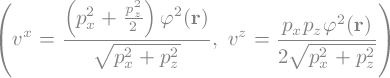

In [17]:
gmeq.rdotx_pxpz_eqn, gmeq.rdotz_pxpz_eqn

In [18]:
gmeq.rdotx_pxpz_eqn.subs({px:px_,pz:pz_}), gmeq.rdotz_pxpz_eqn.subs({px:px_,pz:pz_})

In [19]:
vx_ = gmeq.rdotx_pxpz_eqn.rhs.subs({varphi_r:varphi_, px:px_, pz:pz_})
vz_ = gmeq.rdotz_pxpz_eqn.rhs.subs({varphi_r:varphi_, px:px_, pz:pz_})
Eq(rdotx,vx_), Eq(rdotz,vz_)

and compute the corresponding surface tilt $\beta$ and ray angle $\alpha$:

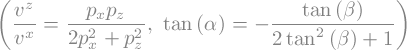

In [20]:
(gmeq.rdotz_on_rdotx_eqn, gmeq.tanalpha_beta_eqn)

In [21]:
gmeq.tanalpha_rdot_eqn.subs({rdotx:vx_, rdotz:vz_})

In [22]:
tanbeta_ = gmeq.tanbeta_pxpz_eqn.rhs.subs({px:px_,pz:pz_})
# tanalpha_ = gmeq.tanalpha_pxpz_eqn.rhs.subs({px:px_,pz:pz_})
tanalpha_ = gmeq.tanalpha_beta_eqn.rhs.subs({tan(beta):tanbeta_})
Eq(tan(beta),tanbeta_), Eq(tan(alpha),tanalpha_)

In [23]:
Eq(beta,N(atan(tanbeta_)*180/pi)), Eq(alpha,N(atan(tanalpha_)*180/pi))

# Lagrangian $L=\frac{1}{2}F^2$  via Legendre transform

Recall the Hamiltonian:

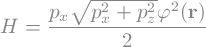

In [24]:
gmeq.H_eqn

and perform the Legendre transform to get the Lagrangian, albeit in T*M coordinates:

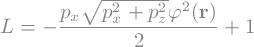

In [25]:
L_eqn = simplify(expand((Eq(L, 1-H).subs({H: gmeq.H_eqn.rhs}))))
L_eqn

Recall the ray velocity vector components obtained from Hamilton's equations:

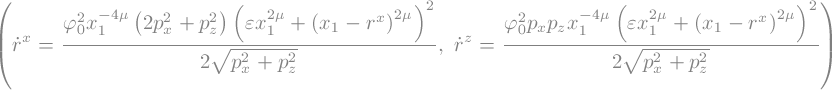

In [26]:
gmeq.hamiltons_eqns[0], gmeq.hamiltons_eqns[1]

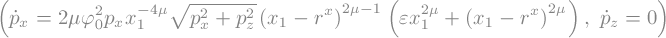

In [27]:
gmeq.hamiltons_eqns[2], gmeq.hamiltons_eqns[3]

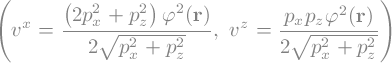

In [28]:
vx_eqn = factor(gmeq.rdotx_pxpz_eqn)
vz_eqn = gmeq.rdotz_pxpz_eqn
vx_eqn, vz_eqn

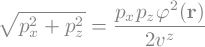

In [29]:
p_px_pz_vz_eqn = Eq(sqrt(px**2+pz**2), solve(vz_eqn, sqrt(px**2+pz**2))[0])
p_px_pz_vz_eqn

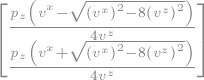

In [30]:
Matrix( solve(vx_eqn.subs(e2d(p_px_pz_vz_eqn)),px) )

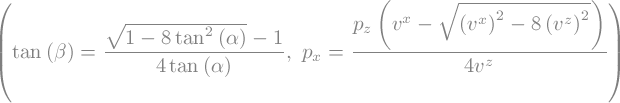

In [31]:
px_pz_vx_vz_eqn = Eq(px, solve( gmeq.tanbeta_alpha_eqns[0]
                            .subs(e2d(gmeq.tanalpha_rdot_eqn))
                            .subs(e2d(gmeq.tanbeta_pxpz_eqn)), px)[0])
gmeq.tanbeta_alpha_eqns[0], px_pz_vx_vz_eqn

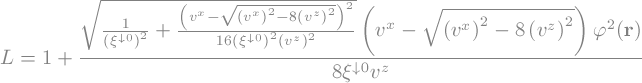

In [32]:
L_simple_eqn = (
    L_eqn.subs(e2d(px_pz_vx_vz_eqn)).subs({pz:pz_0}).subs(e2d(gmeq.pz0_xiv0_eqn))
)
L_simple_eqn

In [33]:
N(L_simple_eqn.subs({tan(beta):tanbeta_, rdotx:vx_, 
                rdotz:vz_, xiv:xiv_0, varphi_r:varphi_}).subs(sub))

# Lagrangian $L=\frac{1}{2}F^2$ from metric tensor

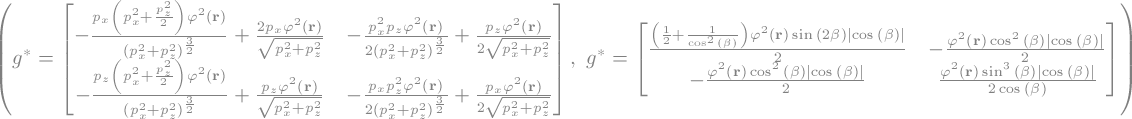

In [34]:
gstar_tanbeta_eqn = simplify( gmeq.gstar_varphi_pxpz_eqn
                             .subs({gmeq.px_pz_tanbeta_eqn.lhs:gmeq.px_pz_tanbeta_eqn.rhs}) )
gmeq.gstar_varphi_pxpz_eqn, gstar_tanbeta_eqn

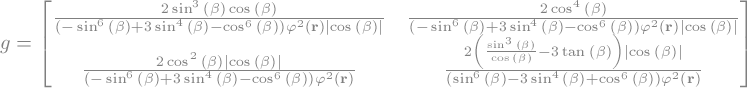

In [35]:
g_xi_tanbeta_eqn = Eq(g, simplify(gstar_tanbeta_eqn.rhs.inverse()))
g_xi_tanbeta_eqn

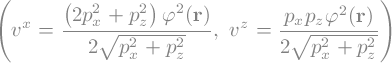

In [36]:
factor(gmeq.rdotx_pxpz_eqn), gmeq.rdotz_pxpz_eqn

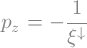

In [37]:
gmeq.pz_xiv_eqn

The following equation ONLY works along geodesics, i.e., ray trajectories.

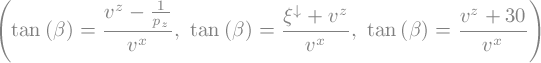

In [38]:
# tanbeta_rdotxz_pz_eqn = Eq(tan(beta), (rdotz - 1/pz)/rdotx )
# tanbeta_rdotxz_xiv_eqn = tanbeta_rdotxz_pz_eqn.subs({pz:pz_xiv_eqn.rhs})
( gmeq.tanbeta_rdotxz_pz_eqn, gmeq.tanbeta_rdotxz_xiv_eqn, 
  gmeq.tanbeta_rdotxz_xiv_eqn.subs({xiv:xiv_0}).subs(sub) )

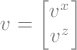

In [39]:
rdot_def_eqn = Eq(rdot_vec, Matrix([rdotx, rdotz]))
rdot_def_eqn

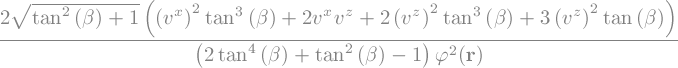

In [40]:
simplify( (rdot_def_eqn.rhs.T*(g_xi_tanbeta_eqn.rhs * rdot_def_eqn.rhs))[0]
     .subs({Abs(cos(beta)):cos(beta)})
     .subs({sin(beta):tan(beta)*cos(beta)})
     .subs({cos(beta):1/sqrt(1+tan(beta)**2)})
).subs({cos(beta):1/sqrt(1+tan(beta)**2)})

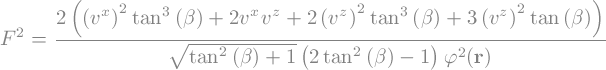

In [41]:
Fsqrd_rdotxz_tanbeta_eqn = Eq(F**2,
    factor(simplify( (rdot_def_eqn.rhs.T*(g_xi_tanbeta_eqn.rhs * rdot_def_eqn.rhs))[0]
         .subs({Abs(cos(beta)):cos(beta)})
         .subs({sin(beta):tan(beta)*cos(beta)})
         .subs({cos(beta):1/sqrt(1+tan(beta)**2)})
    ).subs({sin(beta):sqrt(1-cos(beta)**2)}).subs({cos(beta):1/sqrt(1+tan(beta)**2)}))
                             )
Fsqrd_rdotxz_tanbeta_eqn

In [42]:
(numer(Fsqrd_rdotxz_tanbeta_eqn.rhs).subs({tan(beta):tanbeta_,rdotz:vz_,rdotx:vx_}),
 denom(Fsqrd_rdotxz_tanbeta_eqn.rhs).subs({tan(beta):tanbeta_,rdotz:vz_,rdotx:vx_}))

In [43]:
Fsqrd_rdotxz_tanbeta_eqn.subs({tan(beta):tanbeta_, 
                    rdotx:vx_, rdotz:vz_, varphi_r:varphi_}).subs(sub)

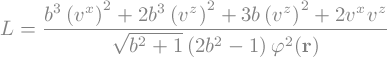

In [44]:
Eq(L, (Fsqrd_rdotxz_tanbeta_eqn.subs({tan(beta):tb}).rhs/2) )

In [45]:
float(sy.deg(atan(sqrt(eta_))))

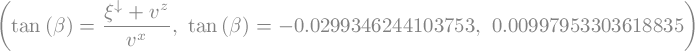

In [46]:
gmeq.tanbeta_rdotxz_xiv_eqn, gmeq.tanbeta_rdotxz_xiv_eqn \
                                .subs({xiv:-xiv_0, rdotx:vx_, rdotz:vz_}) \
                                .subs(sub), tanbeta_

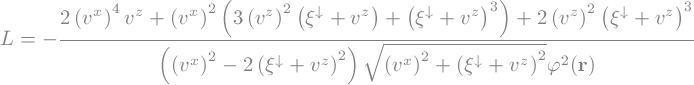

In [47]:
L_rdotxz_xiv_eqn = Eq( L, (simplify( (Fsqrd_rdotxz_tanbeta_eqn.rhs/2)
                                  .subs({tan(beta):gmeq.tanbeta_rdotxz_xiv_eqn.rhs}))) )
L_rdotxz_xiv_eqn

In [48]:
L_rdotxz_xiv_eqn.subs({tan(beta):tanbeta_, 
                       rdotx:vx_, rdotz:vz_, xiv:xiv_0, varphi_r:varphi_}).subs(sub)

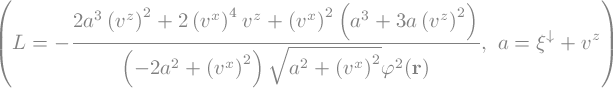

In [49]:
(L_rdotxz_xiv_eqn.subs({xiv+rdotz:ta})), Eq( ta, xiv+rdotz )

# $F$  vs  $F^*$

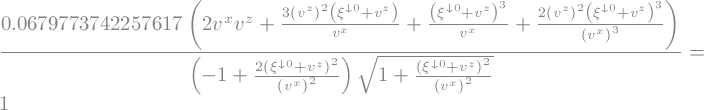

In [50]:
F_parametric_eqn = Eq(((Fsqrd_rdotxz_tanbeta_eqn.rhs)
        .subs(e2d(gmeq.tanbeta_rdotxz_xiv_eqn)).subs({varphi_r:5.42416391692687, xiv:xiv_0})),1)
F_parametric_eqn

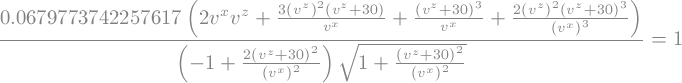

In [51]:
F_parametric_eqn_ = F_parametric_eqn.subs({xiv_0:30})
F_parametric_eqn_

In [52]:
vz_array = np.linspace(0.0001, 8, 100)
vx_poly_eqn = sy.poly(F_parametric_eqn_)
vx_poly_lambda = lambdify( [rdotx,rdotz], vx_poly_eqn.as_expr() )
dvx_poly_lambda = lambdify( [rdotx,rdotz], diff(vx_poly_eqn.as_expr(),rdotx) )

vx_solutions = lambda vx_guess_: np.array([
    (root_scalar( vx_poly_lambda, args=(vz_),fprime=dvx_poly_lambda, 
                 method='newton', x0=vx_guess_ )).root for vz_ in vz_array])
vx_array = vx_solutions(10)

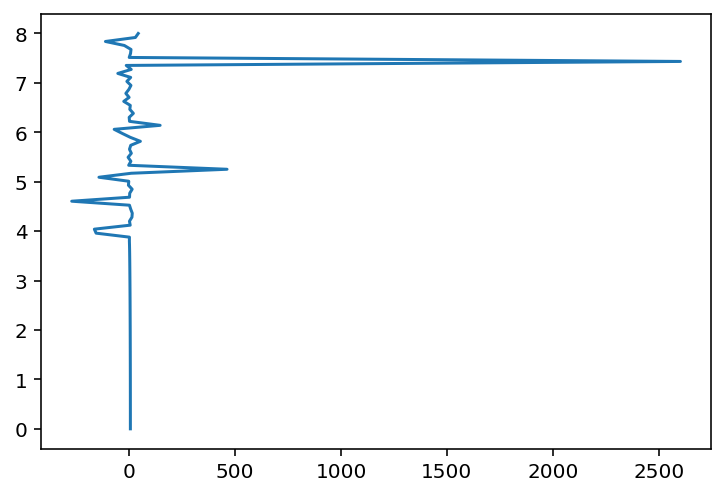

In [53]:
from matplotlib import pyplot as plt
plt.plot(vx_array,vz_array)
# plt.ylim(0,)
# plt.xlim(0,max(vx_array)*1.02);
# plt.plot(5.64880183960402,1.03775116238436, 'o')
axes = plt.gca()
# axes.set_aspect(1)

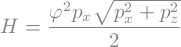

In [54]:
gmeq.H_eqn.subs({varphi_r:varphi})

In [55]:
varphi__ = 1
Eq(varphi,varphi__)

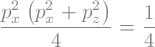

In [56]:
H_parametric_eqn = Eq(gmeq.H_eqn.rhs**2,Rational(1,4)).subs({varphi_r:varphi__, xiv:xiv_0})
H_parametric_eqn

In [57]:
Eq(4*gmeq.H_eqn.rhs**2,1).subs({px:px_min}).subs({varphi_r:varphi})

In [58]:
if eta_==Rational(3,2):
    pz_min_eqn = Eq(pz_min,
        (solve(Eq( ((solve(Eq(4*gmeq.H_eqn.rhs**2,1)
                           .subs({varphi_r:varphi}),px**2)[2]).args[0].args[0].args[0])**2, 0)
          ,pz**4)[0])**Rational(1,4))
    px_min_eqn = Eq(px_min,
            solve(simplify(gmeq.H_eqn.subs({varphi_r:varphi})
                           .subs({pz:pz_min_eqn.rhs})).subs({H:Rational(1,2)}),px)[0] )
    tanbeta_max_eqn = Eq(tan(beta_max), ((px_min/pz_min).subs(e2d(px_min_eqn))).subs(e2d(pz_min_eqn)))
    tanbeta_max = float(N(tanbeta_max_eqn.rhs))
else:
    pz_min_eqn = Eq(pz_min, 0)
    px_min_eqn = Eq(px_min, 
                    sqrt(solve(Eq((
                    solve(Eq(4*gmeq.H_eqn.rhs**2,1).subs({varphi_r:varphi}),pz**2)[:])[0],0)
                                   ,px**2)[1]))
    tanbeta_max_eqn = Eq(tan(beta_max),sy.oo)
    tanbeta_max = None

px_min_eqn, pz_min_eqn, tanbeta_max_eqn, tanbeta_max

(Eq(p_{x_\text{min}}, 1/\varphi),
 Eq(p_{z_\text{min}}, 0),
 Eq(tan(\beta_{\text{max}}), oo),
 None)

In [59]:
px_min_ = round(float(N(px_min_eqn.rhs.subs({varphi:varphi__}))),4)
pz_min_ = round(float(N(pz_min_eqn.rhs.subs({varphi:varphi__}))),8)
px_min_, -pz_min_, np.rad2deg(np.arctan(px_min_/pz_min_)) if pz_min_>0 else None

(1.0, -0.0, None)

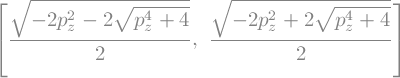

In [60]:
px_H_solns = [simplify(sqrt(soln)) for soln in solve( H_parametric_eqn ,px**2)]
px_H_solns

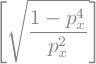

In [61]:
pz_H_solns = [simplify(sqrt(soln)).subs({Abs(px):px}) for soln in solve( H_parametric_eqn ,pz**2)]
pz_H_solns

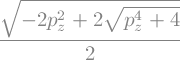

In [62]:
px_H_soln_ = [soln for soln in px_H_solns if Abs(sy.im(N(soln.subs({pz:1}))))<1e-10][0]
px_H_soln_
#  if N(Abs(sy.im(soln.subs({varphi_r:varphi__,pz:pz_}))))<1e-10

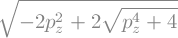

In [63]:
px_H_lambda = lambdify( [pz], simplify(px_H_soln_) )
numer(simplify(px_H_soln_))

In [64]:
if eta_==Rational(3,2):
    pz_max_ = 10**4
else:
    pz_max_ = 10**2
pz_array = -10**np.linspace(np.log10(pz_min_ if pz_min_>0 else 1e-6), np.log10(pz_max_), 1000)
px_array = px_H_lambda(pz_array)
p_array = np.vstack([px_array,pz_array]).T
modp_array = norm(p_array,axis=0)
np.rad2deg(np.arctan(-px_array[0]/pz_array[0])), np.rad2deg(np.arctan(gmeq.tanbeta_crit)), \
    Eq(beta_crit, round(N(sy.deg(atan(gmeq.tanbeta_crit_eqn.rhs))),2))
del px_array, pz_array
# p_infc_array, p_supc_array

In [65]:
px_poly_eqn = sy.poly(H_parametric_eqn)
px_poly_lambda = lambdify( [px,pz], px_poly_eqn.as_expr() )
dpx_poly_lambda = lambdify( [px,pz], diff(px_poly_eqn.as_expr(),px) )

px_solutions = lambda px_guess_: np.array([
    (root_scalar( px_poly_lambda, args=(pz_),fprime=dpx_poly_lambda, 
                 method='newton', x0=px_guess_ )).root for pz_ in p_array[:,1]])
px_newton_array = px_solutions(10)

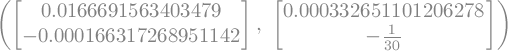

In [66]:
v_from_gstar_lambda_tmp = lambdify((px,pz),
                N(gmeq.gstar_varphi_pxpz_eqn.subs({varphi_r:varphi__}).rhs*Matrix([px,pz])))
v_from_gstar_lambda = lambda px_,pz_: (v_from_gstar_lambda_tmp(px_,pz_)).flatten()
Matrix(v_from_gstar_lambda(px_,pz_)),(Matrix([px_,pz_]))

In [67]:
pz_ = 2
px_ = px_H_lambda(pz_)
v_ = (v_from_gstar_lambda(px_,pz_))
np.dot(np.array([px_,pz_]),v_)

In [68]:
p_infc_array = p_array[(-p_array[:,0]/p_array[:,1])<=gmeq.tanbeta_crit]
p_supc_array = p_array[(-p_array[:,0]/p_array[:,1])>=gmeq.tanbeta_crit]

In [69]:
v_lambda = lambda pa: np.array([(v_from_gstar_lambda(px_,pz_)) for px_,pz_ in pa])
v_infc_array = v_lambda(p_infc_array)
v_supc_array = v_lambda(p_supc_array)
v_array = v_lambda(p_array)

In [70]:
def Fstar_F_rectlinear(do_zoom=False):
    fig = gr.create_figure(job_name+'_Fstar_F_rectlinear'+('_zoom' if do_zoom else ''), fig_size=(7,9))
#     eta_xy_label = [0,0]
#     plt.xlim(0,2)
#     plt.ylim(-4,0.6)
    if do_zoom:
        if eta_==Rational(3,2):
            plt.xlim(0.98,1.07)
            plt.ylim(0.15,0.23)
            eta_xy_label = [0.2,0.85]
        else:
            plt.xlim(0.7,1.2)
            plt.ylim(-0.4,0)
            eta_xy_label = [0.8,0.8]
    else:
        if eta_==Rational(3,2):
            plt.xlim(0,2)
            plt.ylim(-4,0.6)
            eta_xy_label = [0.7,0.8]
        else:
            plt.xlim(0,2.5)
            plt.ylim(-2,0)
            eta_xy_label = [0.8,0.7]

    # Critical, bounding angles
    # pz_max_ = p_array[-1,1]
    if eta_==Rational(3,2):
        pz_max_ = -1.5
    else:
        pz_max_ = -1.5
    px_abmax_ = -pz_max_*(tanbeta_max if tanbeta_max is not None else 1)
    pz_abmax_ = pz_max_
    vx_abmax_,vz_abmax_ = v_from_gstar_lambda(px_abmax_,pz_abmax_)
    px_abcrit_ = -pz_max_*gmeq.tanbeta_crit
    pz_abcrit_ = pz_max_
    vx_abcrit_,vz_abcrit_ = v_from_gstar_lambda(px_abcrit_,pz_abcrit_)

    # Lines visualizing critical, bounding angles: ray velocity
    plt.plot([0,vx_abcrit_],[0,vz_abcrit_], 
             '-.', color='DarkRed', lw=1, label=r'$\alpha_{\mathrm{c}}$')
    if eta_==Rational(3,2):
        plt.plot([0,vx_abmax_],[0,vz_abmax_], 
                 '-', color='r', alpha=0.4, lw=2, label=r'$\alpha_{\mathrm{lim}}$')

    # Indicatrix aka F=1 for rays
    plt.plot(v_supc_array[:,0],v_supc_array[:,1], 'Red', lw=2, ls='-', 
             label=r'$F=1$,  $\beta\geq\beta_\mathrm{c}$')
    plt.plot(v_infc_array[:,0],v_infc_array[:,1], 'DarkRed', lw=1 if eta_==Rational(3,2) and not do_zoom else 2, 
             ls='-', 
             label=r'$F=1$,  $\beta<\beta_\mathrm{c}$')

    # Lines visualizing critical, bounding angles: normal slowness
    if eta_==Rational(3,2) and not do_zoom:
        plt.plot([0,px_abmax_],[0,pz_abmax_], 
                 '-', 'b', alpha=0.4, lw=1.5, label=r'$\beta_{\mathrm{max}}$')
    if not do_zoom:
        plt.plot([0,px_abcrit_],[0,pz_abcrit_], 
                 '--', color='DarkBlue', lw=1, label=r'$\beta_{\mathrm{c}}$')

    # Figuratrix aka F*=1 for surfaces
    if not do_zoom:
        plt.plot(p_supc_array[:,0],p_supc_array[:,1], 'Blue', lw=2, ls='-', 
                 label=r'$F^*\!\!=1$,  $\beta\geq\beta_\mathrm{c}$')
        plt.plot(p_infc_array[:,0],p_infc_array[:,1], 'DarkBlue', lw=2, ls='-', 
                 label=r'$F^*\!\!=1$,  $\beta<\beta_\mathrm{c}$')

    # px_, pz_ = p_array[0]
    # vx_,vz_ = v_from_gstar_lambda(px_,pz_)
    # plt.plot([px_],[pz_], 'o', color='DarkBlue', ms=9, fillstyle='none')
    # plt.plot([vx_],[vz_], 'o', color='DarkRed', ms=9, fillstyle='none')

    pz_ = -float(solve(H_parametric_eqn.subs({px:pz*(gmeq.tanbeta_crit)}),pz)[0])
    px_ = px_H_lambda(pz_)
    vx_,vz_ = v_from_gstar_lambda(px_,pz_)
    if eta_!=Rational(3,2):
        plt.plot([vx_],[-vz_], 'o', color='DarkRed', ms=5)
    if not do_zoom:
        plt.plot([px_],[-pz_], 'o', color='DarkBlue', ms=5)

    plt.xlabel(r'$p_x$ (for $F^*$)  or  $v^x$ (for $F$)', fontsize=14)
    plt.ylabel(r'$p_z$ (for $F^*$)  or  $v^z$ (for $F$)', fontsize=14)

    axes = plt.gca()
    axes.set_aspect(1)    
    plt.text(*eta_xy_label, rf'$\eta={gmeq.eta}$', transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             fontsize=15, color='k')

    if eta_==Rational(3,2):
        if do_zoom:
            plt.legend(loc='lower right')
        else:
            plt.legend(loc='lower left')
    else:
        if do_zoom:
            plt.legend(loc='upper left')
        else:
            plt.legend(loc='lower right')

    plt.grid(True, ls=':')

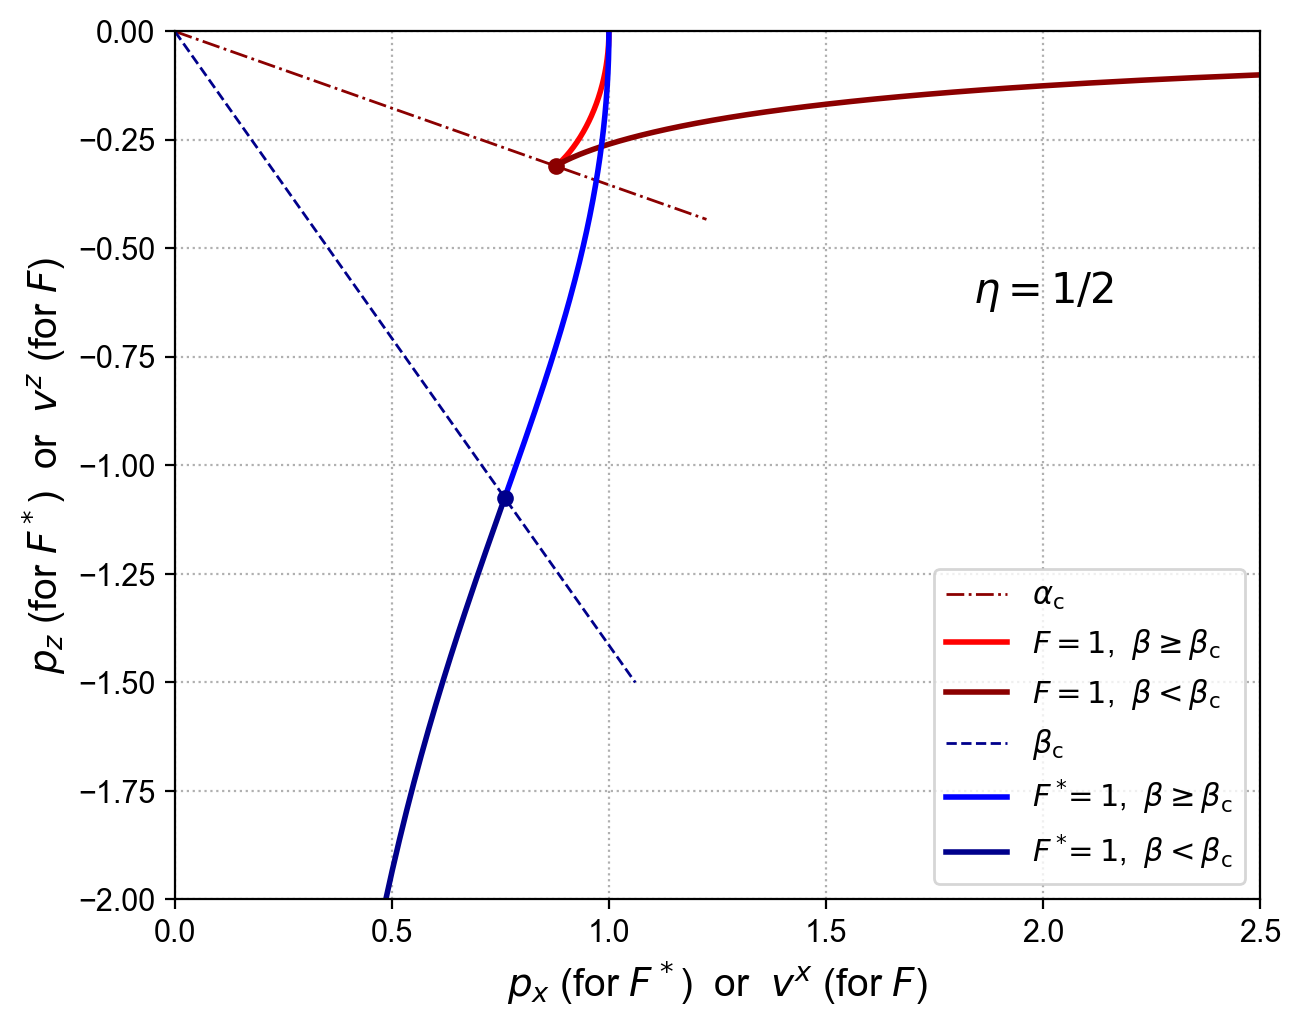

In [71]:
Fstar_F_rectlinear(do_zoom=False)

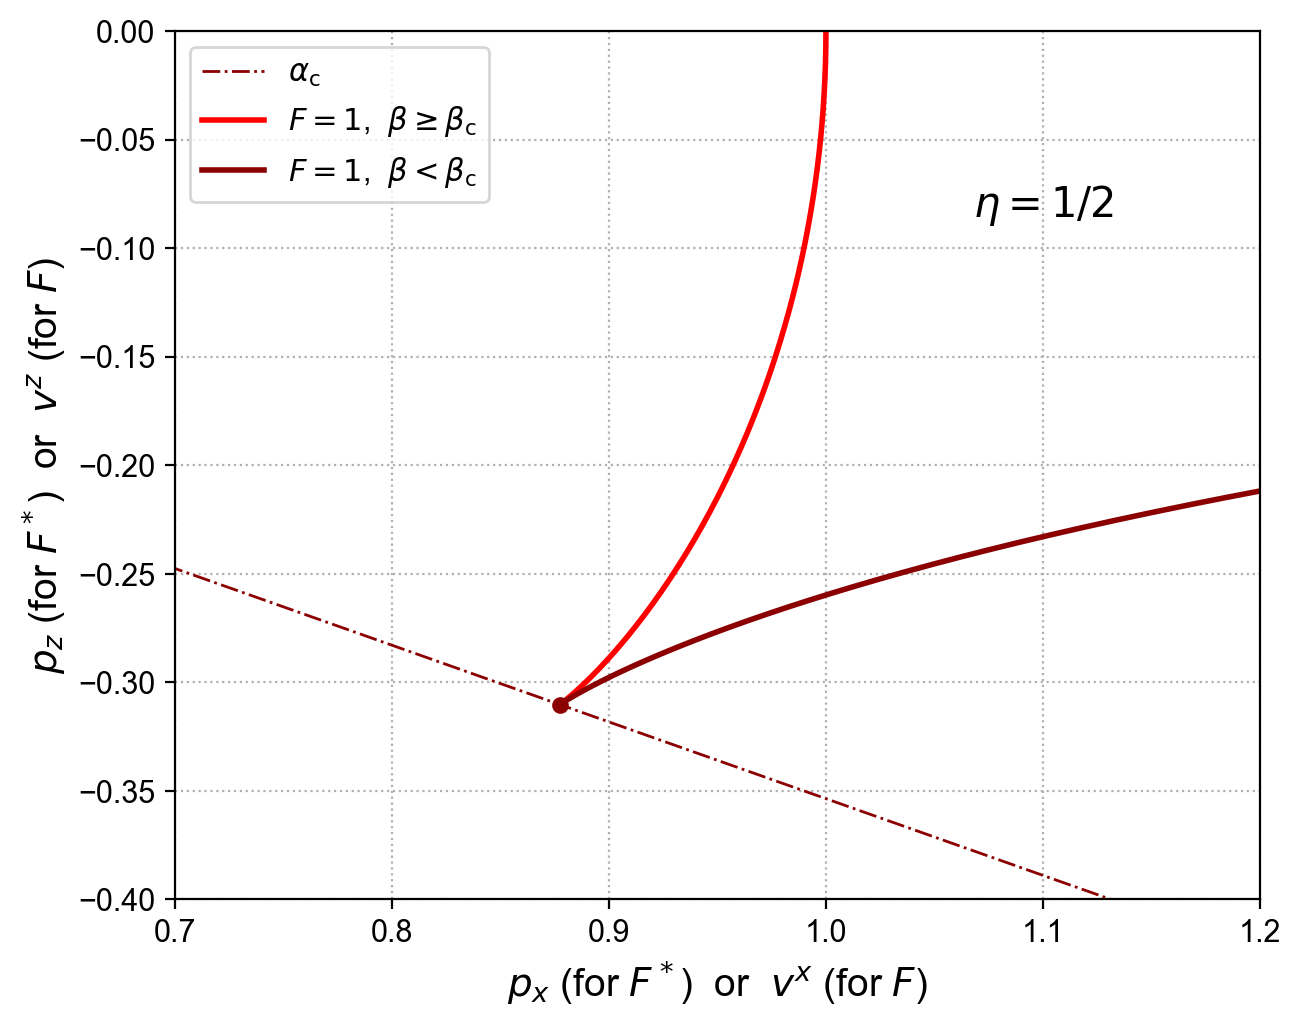

In [72]:
Fstar_F_rectlinear(do_zoom=True)

In [104]:
def Fstar_F_polar():
    fig = gr.create_figure(job_name+'_Fstar_F_polar', fig_size=(7,7))

    if eta_>1:
        r_min_ = 0.1
        r_max_ = 100
        scale_fn = lambda a: np.log10(a)
        alpha_fn = lambda a: np.pi-a
    else:
        r_min_ = 0.1
        r_max_ = 10
        scale_fn = lambda a: np.log10(a)
        alpha_fn = lambda a: a
    v_scale_fn = lambda v: scale_fn(v)*1

    unit_circle_array = np.array([[theta_,1] for theta_ in np.linspace(0,(np.pi/2)*1.2,100)])
    plt.polar(unit_circle_array[:,0], scale_fn(unit_circle_array[:,1]), 
              '-', color='g', lw=1, label='unit circle')

    
    
    # Lines visualizing critical, bounding angles: ray velocity
    plt.polar([np.pi/2+(np.arctan(gmeq.tanalpha_crit))]*2, [scale_fn(r_min_),scale_fn(r_max_)], 
              '-.', color='DarkRed', lw=1, label=r'$\alpha_{\mathrm{c}}$')
    if eta_==Rational(3,2):
        plt.polar([np.pi/2+(np.arctan(gmeq.tanalpha_crit))]*2, [scale_fn(r_min_),scale_fn(r_max_)], 
                  '-', color='r', alpha=0.4, lw=2, label=r'$\alpha_{\mathrm{lim}}$')


    plt.polar(alpha_fn(np.arcsin(v_supc_array[:,0]/norm(v_supc_array, axis=1))),
              v_scale_fn(norm(v_supc_array, axis=1)), 'Red',
              label=r'$F=1$,  $\beta\geq\beta_\mathrm{c}$')
    plt.polar(alpha_fn(np.arcsin(v_infc_array[:,0]/norm(v_infc_array, axis=1))),
              v_scale_fn(norm(v_infc_array, axis=1)), 'DarkRed', lw=None if eta_==Rational(3,2) else None,
              label=r'$F=1$,  $\beta<\beta_\mathrm{c}$')
    
    plt.polar(np.arcsin(p_supc_array[:,0]/norm(p_supc_array, axis=1)),
                  scale_fn(norm(p_supc_array, axis=1)), 'Blue',
                     label=r'$F^*\!\!=1$,  $\beta\geq\beta_\mathrm{c}$')
    plt.polar(np.arcsin(p_infc_array[:,0]/norm(p_infc_array, axis=1)),
                  scale_fn(norm(p_infc_array, axis=1)), 'DarkBlue',
                     label=r'$F^*\!\!=1$,  $\beta<\beta_\mathrm{c}$')

    plt.polar(
        (np.arcsin(p_supc_array[-1,0]/norm(p_supc_array[-1]))
         +np.arcsin(p_infc_array[0,0]/norm(p_infc_array[0])))/2,
        (scale_fn(norm(p_infc_array[0]))+scale_fn(norm(p_supc_array[-1])))/2, 
              'o', color='DarkBlue')
    
    axes = plt.gca()
    axes.set_theta_zero_location('S')
    if eta_>1:
        theta_max_ = 20
        axes.set_thetamax(90+theta_max_)
        axes.text(np.deg2rad(90+theta_max_),axes.get_rmax()/2, r'$\log_{10}{v}$',
                    rotation=theta_max_, ha='center', va='bottom', fontsize=15)
        axes.text(np.deg2rad(-8),axes.get_rmax()/2, r'$\log_{10}{p}$',
                    rotation=90, ha='right', va='bottom', fontsize=15)
        theta_list = [0, 1/6, 2/6, 3/6, np.deg2rad(110)/np.pi]
        xtick_labels = [
            r'$\beta=0^{\!\circ}$',
            r'$\beta=30^{\!\circ}$',
            r'$\beta=60^{\!\circ}$',
            r'$\alpha=0^{\!\circ}$',
            r'$\alpha=20^{\!\circ}$',
        ]
        eta_xy_label = [1.15,0.9]
        legend_xy = [1,0]
        plt.text(*[(np.pi/2)*1.07,0.4], 'convex', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=8, fontsize=15, color='DarkRed')
        plt.text(*[(np.pi/3)*0.925,0.5], 'convex', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=-35, fontsize=15, color='b')
        plt.text(*[(np.pi/6)*0.7,0.85], 'convex', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=68, fontsize=15, color='DarkBlue')
    else:
        theta_max_ = 0
        axes.set_thetamax(90+theta_max_)
        axes.text(np.deg2rad(92+theta_max_),axes.get_rmax()/5, r'$\log_{10}{v}$',
                    rotation=theta_max_, ha='right', va='bottom', fontsize=15)
        axes.text(np.deg2rad(-10),axes.get_rmax()/5, r'$\log_{10}{p}$',
                    rotation=90, ha='right', va='bottom', fontsize=15)
        theta_list = [0, 1/6, 2/6, 3/6]
        xtick_labels = [
            r'$\beta=0^{\!\circ}$',
            r'$\beta=30^{\!\circ}$',
            r'$\beta=60^{\!\circ}, \alpha=-30^{\!\circ}$',
            r'$\beta=90^{\!\circ}, \alpha=0^{\!\circ}$',
        ]
        eta_xy_label = [1.2,0.75]
        legend_xy = [0.9,0]
        plt.text(*[(np.pi/2)*0.94,0.4], 'concave', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=11, fontsize=15, color='DarkRed')
        plt.text(*[(np.pi/2)*0.9,-0.07], 'convex', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=72, fontsize=13, color='r')
        plt.text(*[(np.pi/4)*1.2,0.12], 'convex', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=60, fontsize=15, color='b')
        plt.text(*[(np.pi/6)*0.5,0.4], 'concave', #transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             rotation=50, fontsize=15, color='DarkBlue')
        plt.polar(alpha_fn(np.arcsin(v_supc_array[:,0]/norm(v_supc_array, axis=1))),
                  v_scale_fn(norm(v_supc_array, axis=1)), 'Red')
        
    plt.polar(
        alpha_fn((np.arcsin(v_supc_array[-1,0]/norm(v_supc_array[-1]))
                  +np.arcsin(v_infc_array[0,0]/norm(v_infc_array[0])))/2),
        (v_scale_fn(norm(v_infc_array[0]))+v_scale_fn(norm(v_supc_array[-1])))/2, 
              'o', color='DarkRed')

    if eta_>1:
        plt.polar([np.arctan(tanbeta_max)]*2, [scale_fn(r_min_),scale_fn(r_max_)], 
                  '-', color='b', alpha=0.3, lw=1.5, label=r'$\beta_{\mathrm{max}}$')
    plt.polar([np.arctan(gmeq.tanbeta_crit)]*2, [scale_fn(r_min_),scale_fn(r_max_)], 
              '--', color='DarkBlue', lw=1, label=r'$\beta_{\mathrm{c}}$')


    xtick_posns = [np.pi*theta_ for theta_ in theta_list]
    plt.xticks(xtick_posns, xtick_labels, ha='left', fontsize=15);

    plt.text(*eta_xy_label, rf'$\eta={gmeq.eta}$', transform=axes.transAxes,
             horizontalalignment='center', verticalalignment='center',
             fontsize=17, color='k')
    plt.legend(loc=legend_xy)
        
    axes.tick_params(axis='x', pad=0, left=True, length=5, width=1, direction='out')
    
    axes.set_aspect(1)    
    axes.set_rmax(scale_fn(r_max_))
    axes.set_rmin(scale_fn(r_min_))
    axes.set_thetamin(0)
    plt.grid(False, ls=':');

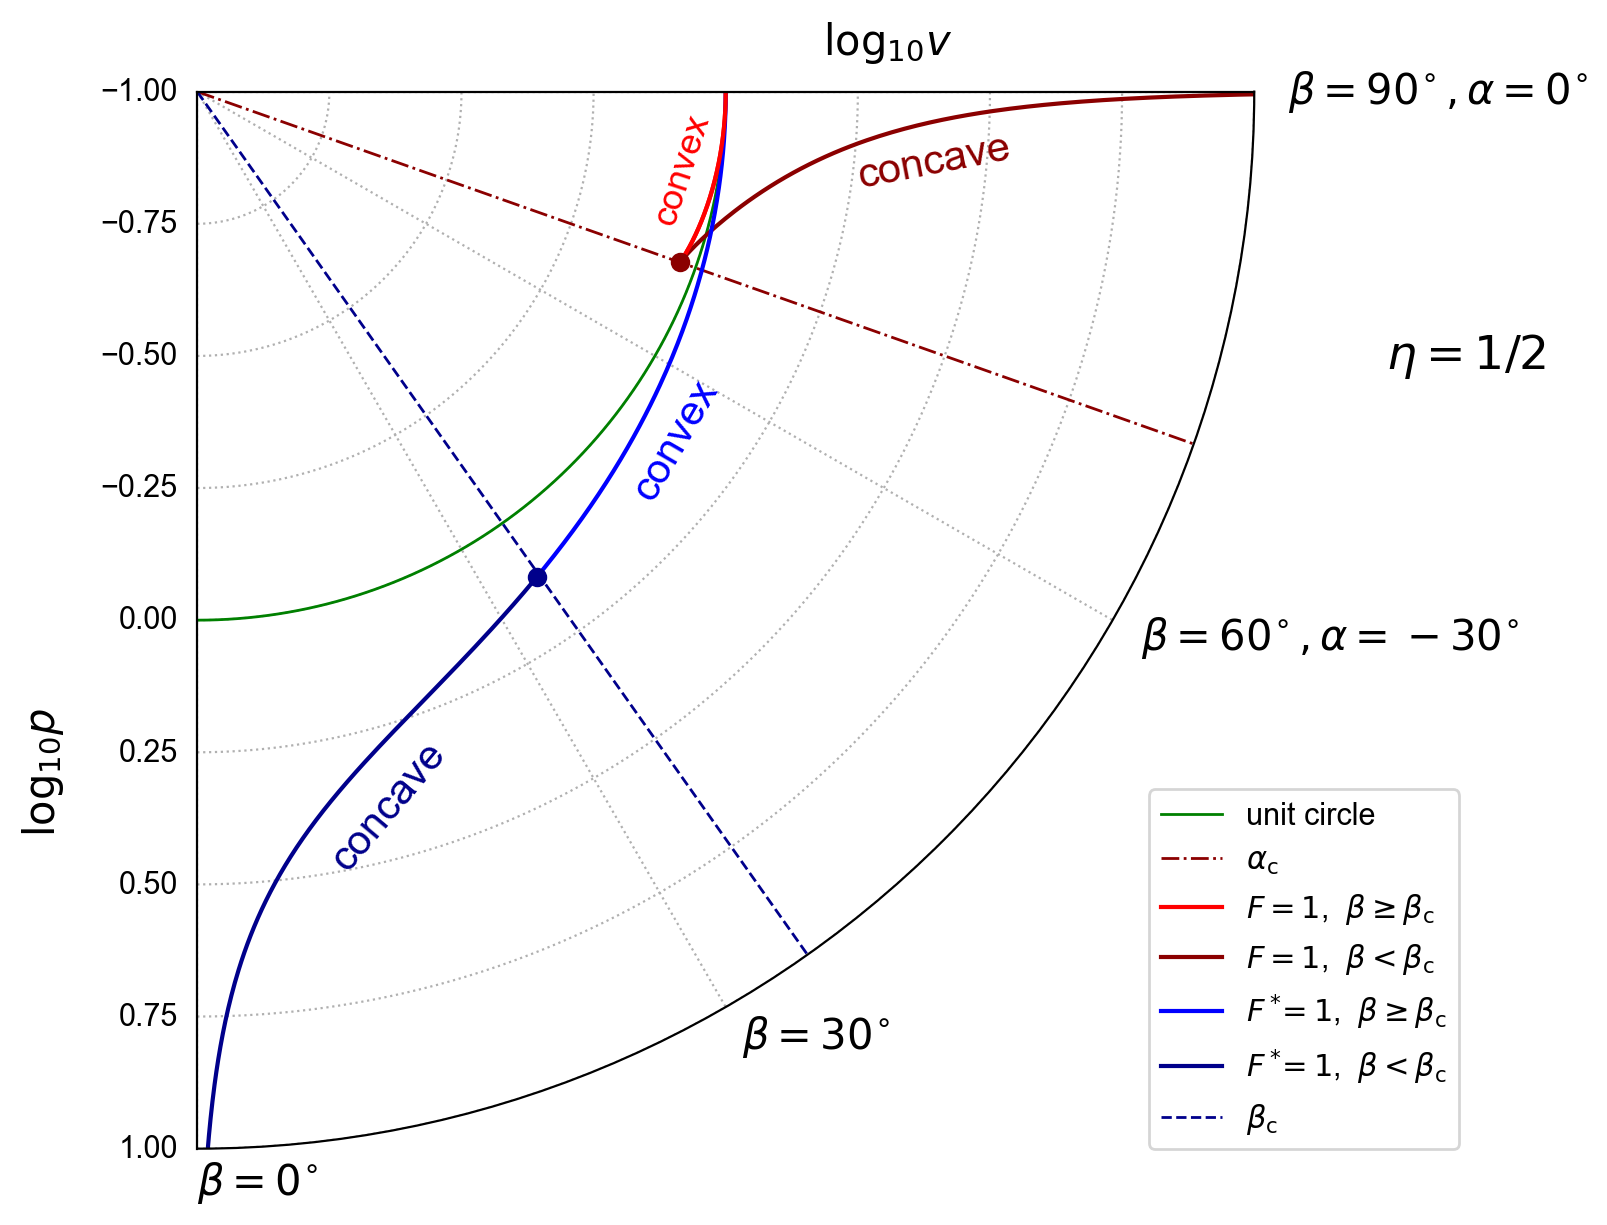

In [105]:
Fstar_F_polar()